In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

import scipy.stats as stats

import statsmodels.api as sm 
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

In [14]:
dir_plots = './plots'

In [62]:
df = pd.read_csv('merged_data.csv')
df.head()

,mergeid,female,age,bmi,activity,ENMO_hour,GGIR_N_valid_hours,hour,measurementday,weekday,...,disease,d1,d2,d3,d4,d5,d6,d7,control,OxCGRT_stay_at_home
0,Bf-031257-01,0,67.0,21.155294,9.0,7.848472,0.5,2am-3am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
1,Bf-031257-01,0,67.0,21.155294,9.0,0.244306,1.0,3am-4am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
2,Bf-031257-01,0,67.0,21.155294,9.0,4.214167,1.0,4am-5am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
3,Bf-031257-01,0,67.0,21.155294,9.0,8.387500,1.0,5am-6am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
4,Bf-031257-01,0,67.0,21.155294,9.0,1.550000,1.0,6am-7am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions


In [16]:
df["OxCGRT_stay_at_home"]

0         No restrictions
1         No restrictions
2         No restrictions
3         No restrictions
4         No restrictions
               ...       
134226    No restrictions
134227    No restrictions
134228    No restrictions
134229    No restrictions
134230    No restrictions
Name: OxCGRT_stay_at_home, Length: 134231, dtype: object

C:\Users\mjbur\AppData\Local\Temp\ipykernel_19184\612731338.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlabels)


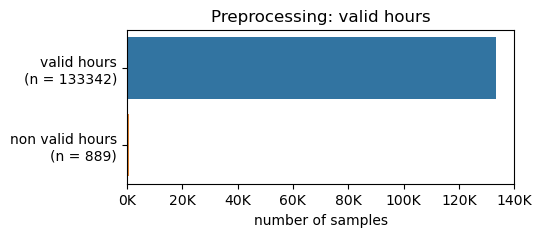

In [17]:
valid_hour_threshold = 0.5

fig = plt.figure(figsize=[5,2])
_valid_hours = len(df[df['GGIR_N_valid_hours']>valid_hour_threshold])
_non_valid_hours = len(df[df['GGIR_N_valid_hours']<=valid_hour_threshold])

data = pd.DataFrame({
    f'valid hours\n(n = {_valid_hours})': [_valid_hours],
    f'non valid hours\n(n = {_non_valid_hours})': [_non_valid_hours],
})

p = sns.barplot(data=data, orient='horizontal')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlabels)
#plt.xticks(rotation=-20)
plt.xlabel("number of samples")

plt.title(f"Preprocessing: valid hours")
plt.show()

Filter out non valid hours

and sedentary behaiviour (sedentary/lying) threshold: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5051724/ (Table2)

In [18]:
valid_hour_threshold = 0.75
df_valid = df.copy()
df_valid.drop(df_valid.loc[df_valid['GGIR_N_valid_hours'] <= valid_hour_threshold].index, inplace=True)
df_valid.head()

,mergeid,female,age,bmi,activity,ENMO_hour,GGIR_N_valid_hours,hour,measurementday,weekday,...,disease,d1,d2,d3,d4,d5,d6,d7,control,OxCGRT_stay_at_home
1,Bf-031257-01,0,67.0,21.155294,9.0,0.244306,1.0,3am-4am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
2,Bf-031257-01,0,67.0,21.155294,9.0,4.214167,1.0,4am-5am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
3,Bf-031257-01,0,67.0,21.155294,9.0,8.387500,1.0,5am-6am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
4,Bf-031257-01,0,67.0,21.155294,9.0,1.550000,1.0,6am-7am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions
5,Bf-031257-01,0,67.0,21.155294,9.0,1.591250,1.0,7am-8am,1,Tuesday,...,control,0,0,0,0,0,0,0,1,No restrictions


In [19]:
group = ["Hypertension", "Diabetes", "OA"]

YVar = df_valid["ENMO_hour"]
XVar1 = df_valid[["d1","d2", "d3", "d4", "d5", "d6", "d7", "control", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
Model = sm.OLS(YVar, XVar1).fit()
print(Model.summary())

                            OLS Regression Results                            
Dep. Variable:              ENMO_hour   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     85.01
Date:                Tue, 24 Jan 2023   Prob (F-statistic):          1.34e-175
Time:                        14:35:13   Log-Likelihood:            -6.5021e+05
No. Observations:              132020   AIC:                         1.300e+06
Df Residuals:                  132009   BIC:                         1.301e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.2802      0.889     45.307      0.0

In [140]:
group = ["Hypertension", "Diabetes", "OA"]

YVar = df_valid["activity"]
XVar1 = df_valid[["d1","d2", "d3", "d4", "d5", "d6", "d7", "control", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
Model = sm.OLS(YVar, XVar1).fit()
print(Model.summary())

                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     988.6
Date:                Mon, 23 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:03:18   Log-Likelihood:            -3.3304e+05
No. Observations:              132020   AIC:                         6.661e+05
Df Residuals:                  132009   BIC:                         6.662e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5153      0.080    130.700      0.0

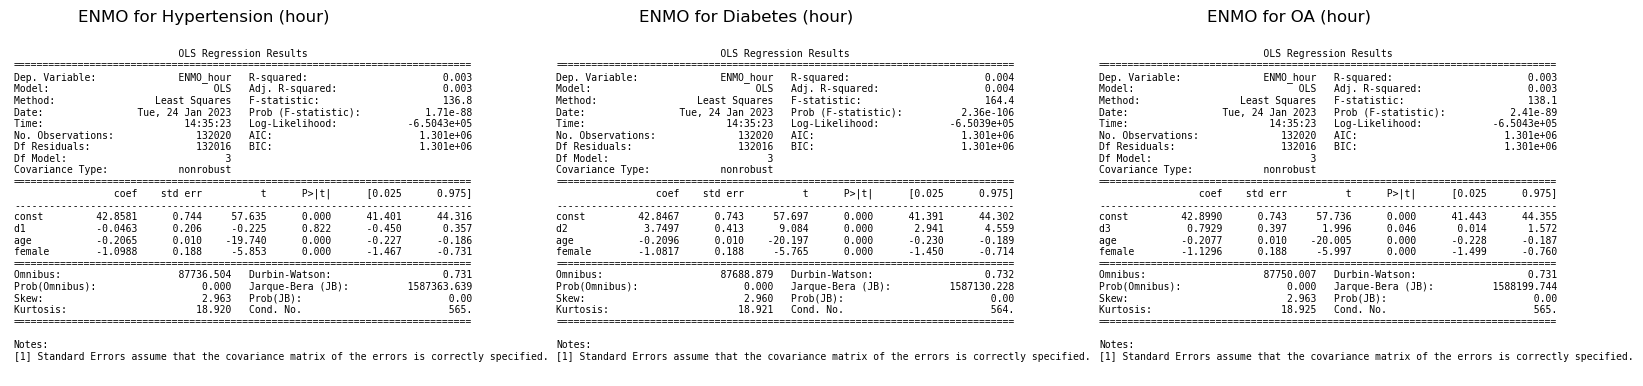

In [20]:
group = ["Hypertension", "Diabetes", "OA"]

YVar = df_valid["ENMO_hour"]
XVar1 = df_valid[["d1", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_valid[["d2", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_valid[["d3", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()
#plt.savefig('./ols_results/hour_output.png')


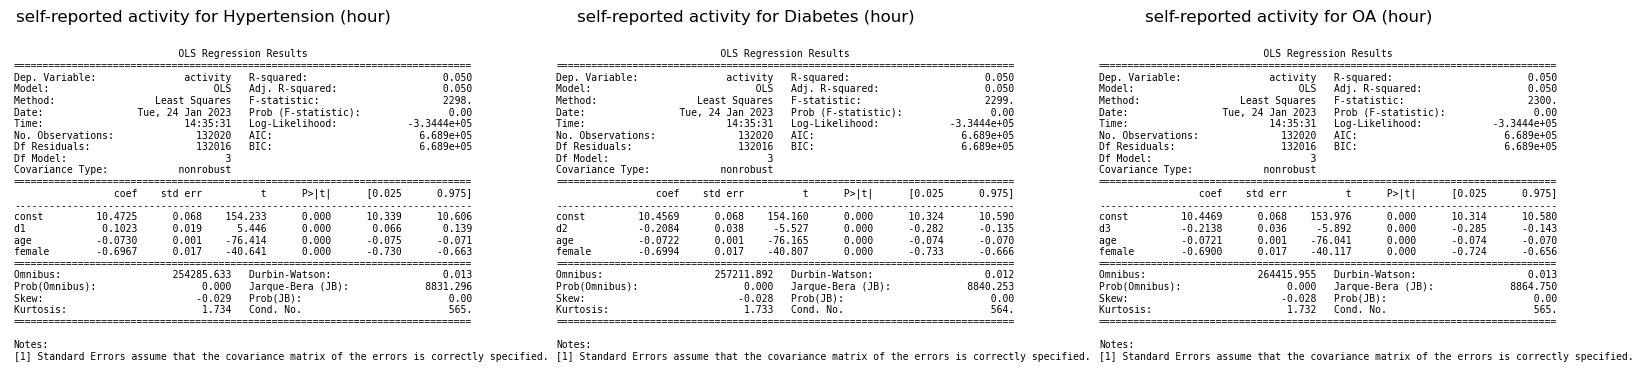

In [21]:
group = ["Hypertension", "Diabetes", "OA"]

YVar = df_valid["activity"]
XVar1 = df_valid[["d1", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_valid[["d2", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_valid[["d3", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"self-reported activity for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

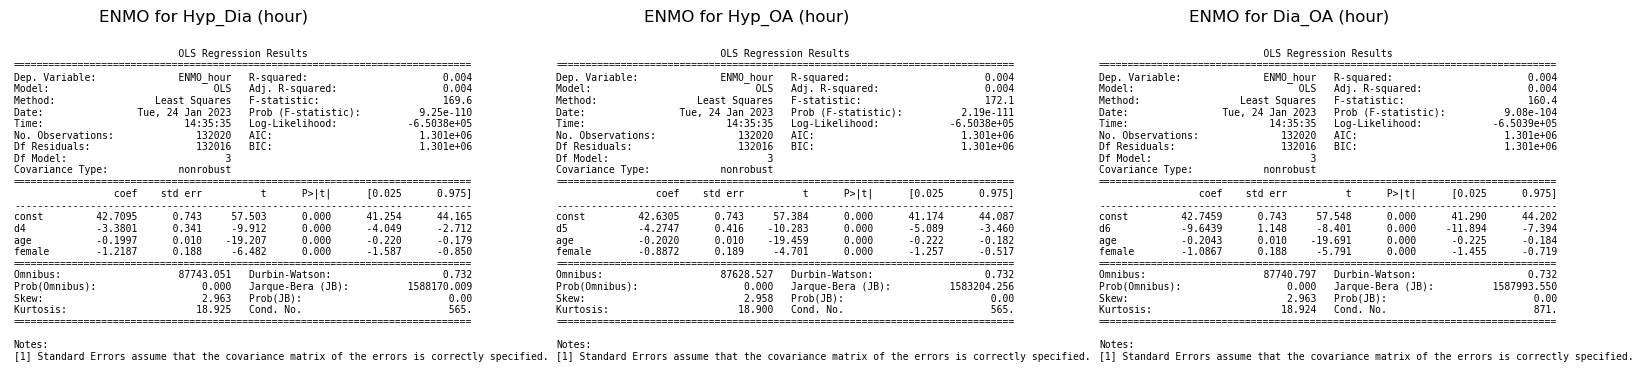

In [22]:
group = ["Hyp_Dia", "Hyp_OA", "Dia_OA"]

YVar = df_valid["ENMO_hour"]
XVar1 = df_valid[["d4", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_valid[["d5", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_valid[["d6", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()
#plt.savefig('./ols_results/hour_output.png')

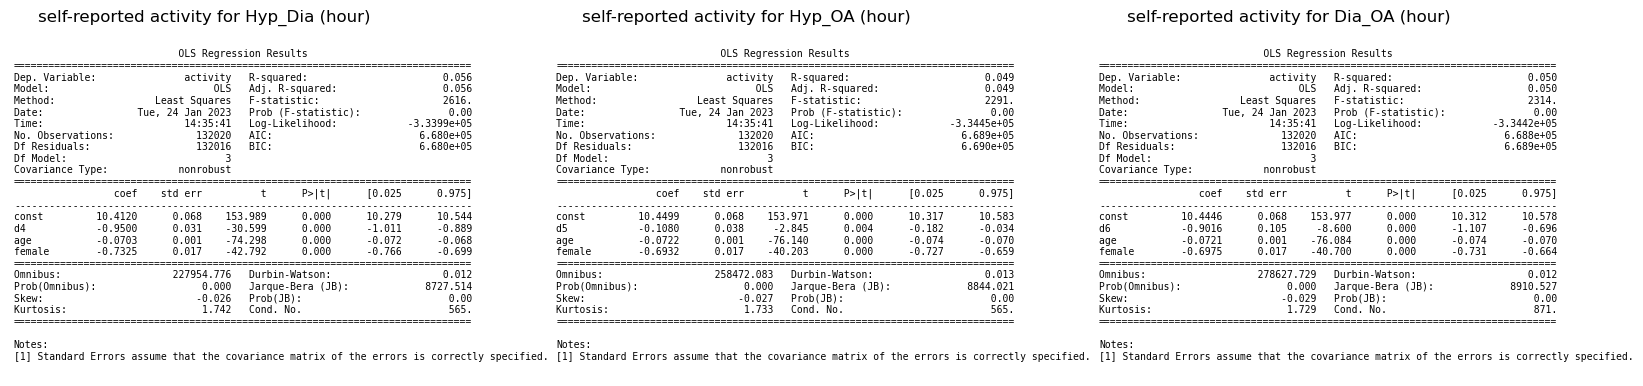

In [23]:
group = ["Hyp_Dia", "Hyp_OA", "Dia_OA"]

YVar = df_valid["activity"]
XVar1 = df_valid[["d4", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_valid[["d5", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_valid[["d6", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"self-reported activity for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

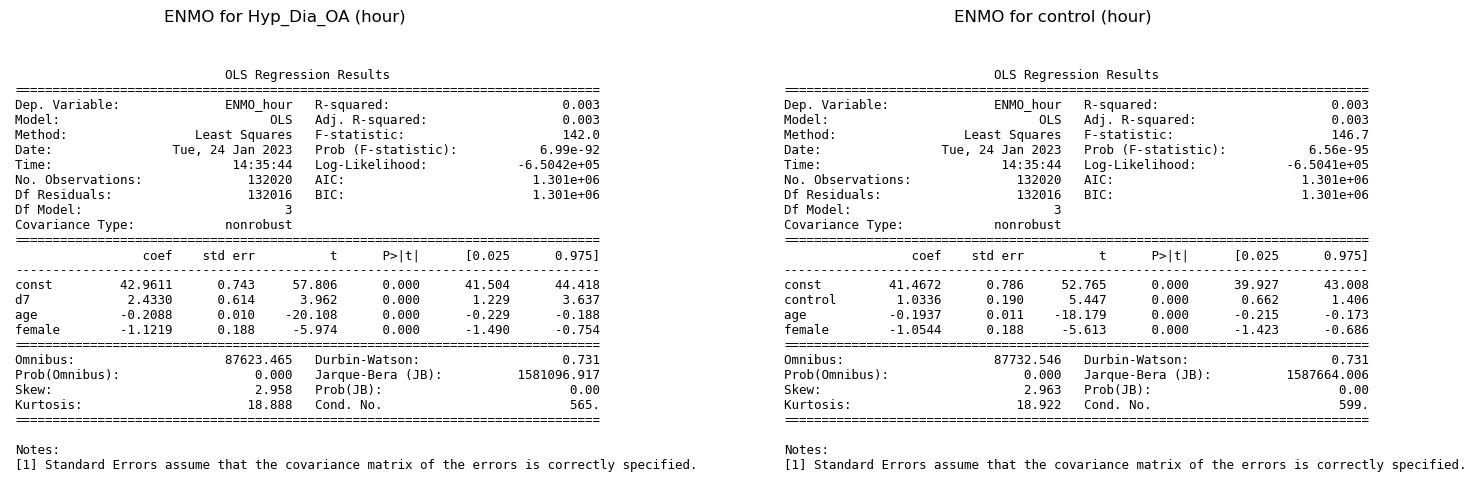

In [24]:
group = ["Hyp_Dia_OA", "control"]

YVar = df_valid["ENMO_hour"]
XVar1 = df_valid[["d7", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_valid[["control", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))
for i in [0,1]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 9}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

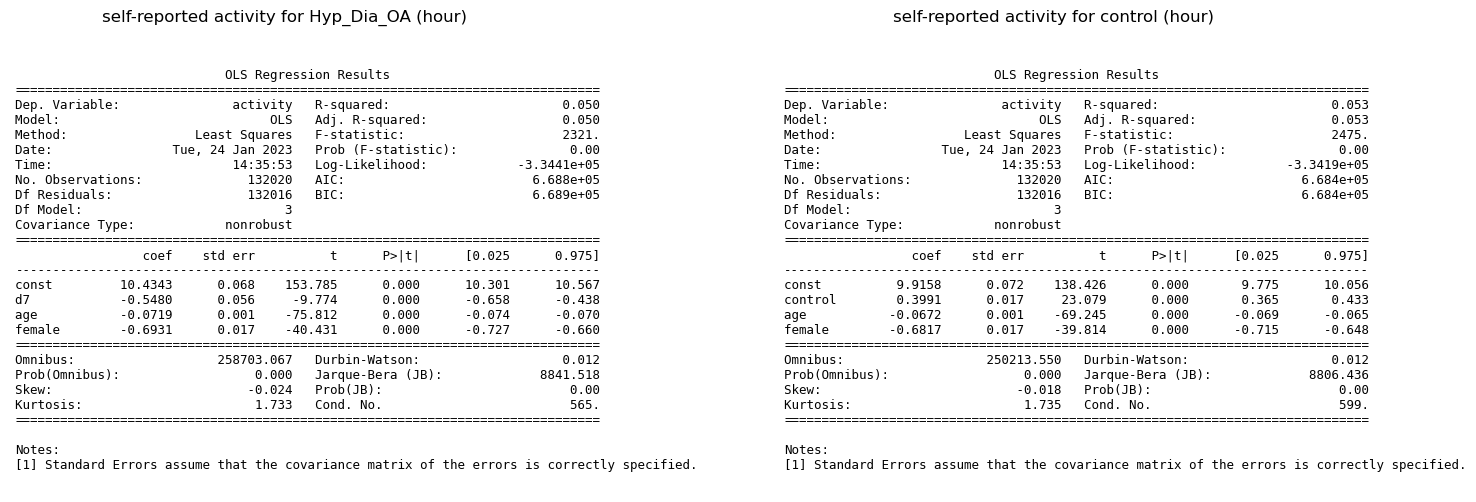

In [25]:
group = ["Hyp_Dia_OA", "control"]

YVar = df_valid["activity"]
XVar1 = df_valid[["d7", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_valid[["control", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))
for i in [0,1]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 9}, fontproperties = 'monospace')
    ax[i].set_title(f"self-reported activity for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

In [26]:
mean_day = df_valid.groupby(["mergeid", "measurementday"], as_index=False).ENMO_hour.mean()
mean_day.rename(columns={"ENMO_hour": "mean_ENMO_day"}, inplace=True)

In [27]:
def calc_ENMO_stats(df, enmo_col='ENMO_hour'):
    df = df.copy()
    mean = df.groupby('mergeid')[enmo_col].mean()
    median = df.groupby('mergeid')[enmo_col].median()
    var = df.groupby('mergeid')[enmo_col].var()
    mean.name = 'mean_ENMO'
    median.name = 'median_ENMO'
    var.name = 'var_ENMO'
    df = pd.merge(left=df, left_on='mergeid', right=mean, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=median, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=var, right_on='mergeid', how='left')
    return df

df_stat= calc_ENMO_stats(df_valid)   
df_stat = df_stat.drop_duplicates(subset='mergeid', keep='first')
cols = ['ENMO_hour','GGIR_N_valid_hours','measurementday', 'hour', 'weekday']
df_stat.drop(cols, inplace=True, axis=1)
df_stat.head(5)

,mergeid,female,age,bmi,activity,month,year,device_id,frequency,position,...,d3,d4,d5,d6,d7,control,OxCGRT_stay_at_home,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,0,67.000000,21.155294,9.0,February,2020,68652.0,50,Left,...,0,0,0,0,0,1,No restrictions,12.295550,9.692708,123.522547
162,Bf-043946-02,1,57.299999,38.446751,2.0,February,2020,30920.0,50,Left,...,0,0,0,0,0,0,No restrictions,14.544591,9.300694,218.288918
317,Bf-073169-01,0,72.500000,25.209202,9.0,March,2020,68652.0,50,Right,...,0,0,0,0,0,0,No restrictions,16.090929,11.452292,537.459251
485,Bf-227520-04,0,56.099998,24.593210,2.0,March,2020,17212.0,50,Right,...,0,0,0,0,0,0,Essential only,11.543128,11.326111,74.794850
533,Bf-286437-02,1,68.099998,30.778702,1.0,February,2020,54007.0,50,Right,...,0,0,0,0,0,0,No restrictions,38.811152,48.127569,367.199181


In [28]:
df_day = pd.merge(mean_day, df_stat)
df_day.drop(["mean_ENMO", "median_ENMO", "var_ENMO"], inplace=True, axis=1)

In [150]:
x = df_day["mean_ENMO_day"]
y = df_day["d1"]
r, p = stats.pearsonr(x, y)
print(r, p)

-0.013167681353128714 0.32160356898025677


In [151]:
x = df_day["activity"]
y = df_day["d1"]
r, p = stats.pearsonr(x, y)
print(r, p)

-0.007999159638856362 0.5471059068754092


In [152]:
group = ["Hypertension", "Diabetes", "OA"]

YVar = df_day["mean_ENMO_day"]
XVar1 = df_day[["d1","d2", "d3", "d4", "d5", "d6", "d7", "control", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)
Model = sm.OLS(YVar, XVar1).fit()
print(Model.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_ENMO_day   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     9.757
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           2.37e-16
Time:                        17:12:00   Log-Likelihood:                -25118.
No. Observations:                5668   AIC:                         5.026e+04
Df Residuals:                    5657   BIC:                         5.033e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.2061      2.617     15.365      0.0

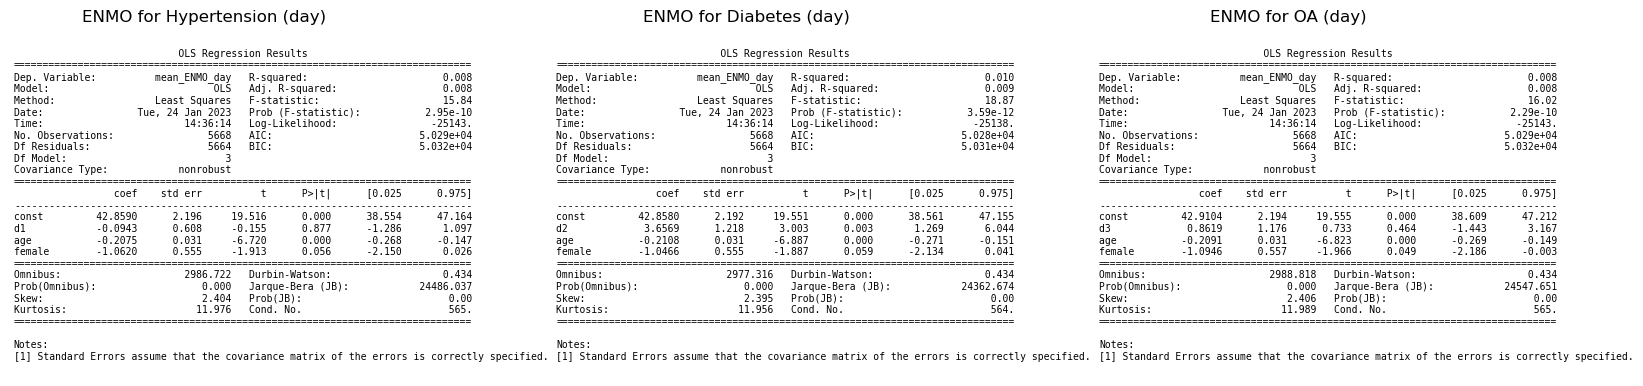

In [29]:
group = ["Hypertension", "Diabetes", "OA"]
YVar = df_day["mean_ENMO_day"]

XVar1 = df_day[["d1", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_day[["d2", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_day[["d3", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO for {group[i]} (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()
#plt.savefig('./ols_results/day_output.png')

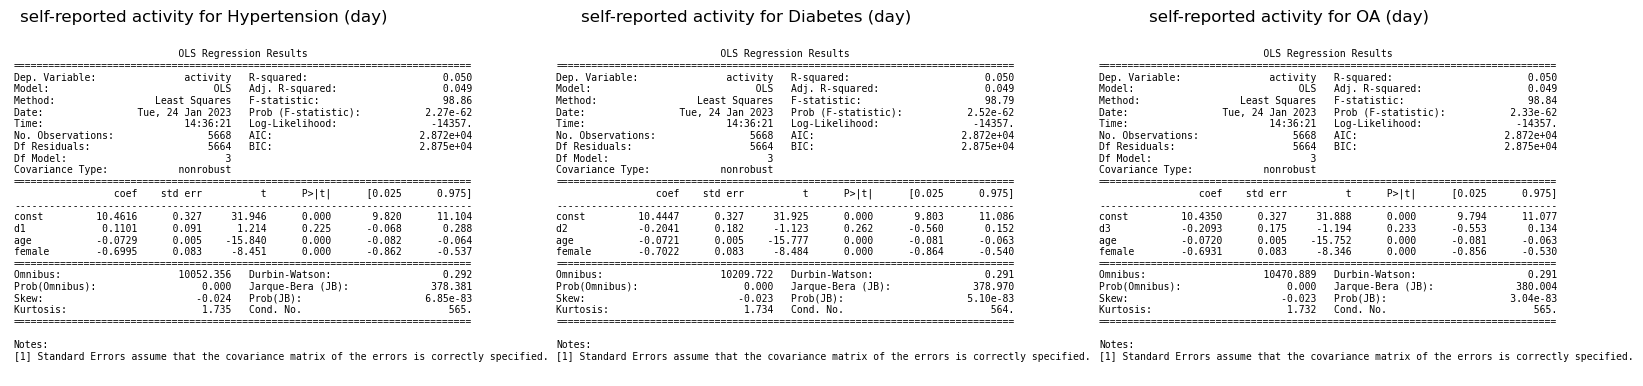

In [30]:
YVar = df_day["activity"]

XVar1 = df_day[["d1", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_day[["d2", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_day[["d3", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"self-reported activity for {group[i]} (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

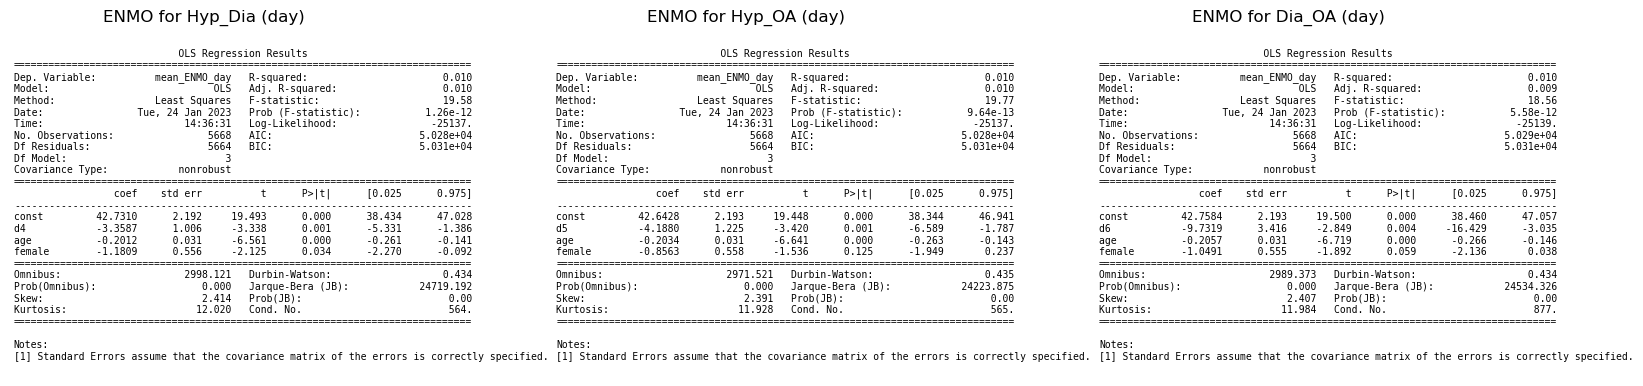

In [31]:
group = ["Hyp_Dia", "Hyp_OA", "Dia_OA"]
YVar = df_day["mean_ENMO_day"]

XVar1 = df_day[["d4", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_day[["d5", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_day[["d6", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO for {group[i]} (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

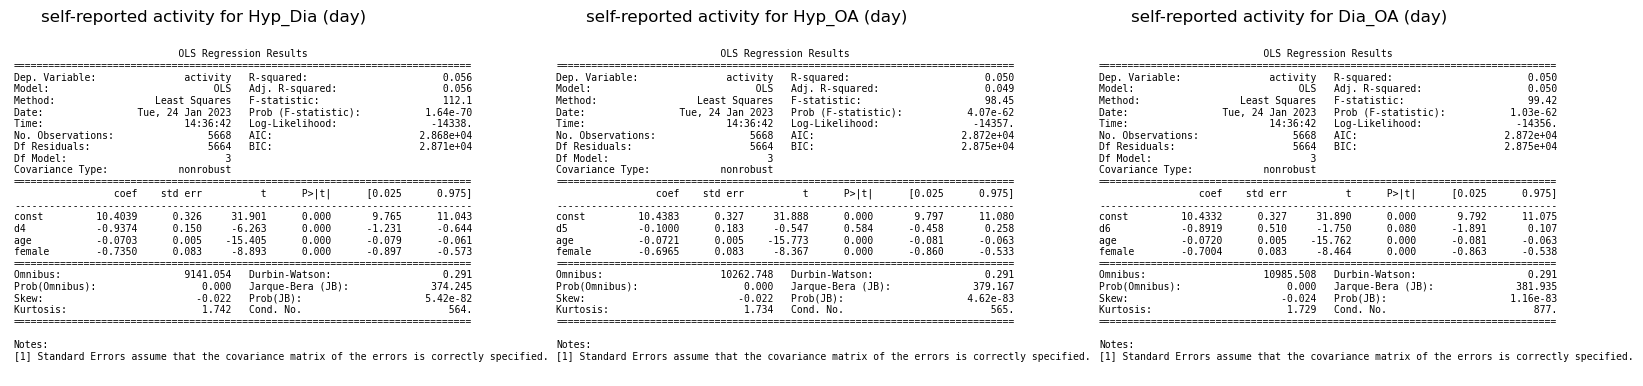

In [32]:
YVar = df_day["activity"]

XVar1 = df_day[["d4", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_day[["d5", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

XVar3 = df_day[["d6", "age", "female"]]
XVar3 = sm.add_constant(XVar3)
models.append(sm.OLS(YVar, XVar3).fit())


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19, 4.5))
for i in [0,1,2]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 7}, fontproperties = 'monospace')
    ax[i].set_title(f"self-reported activity for {group[i]} (day)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

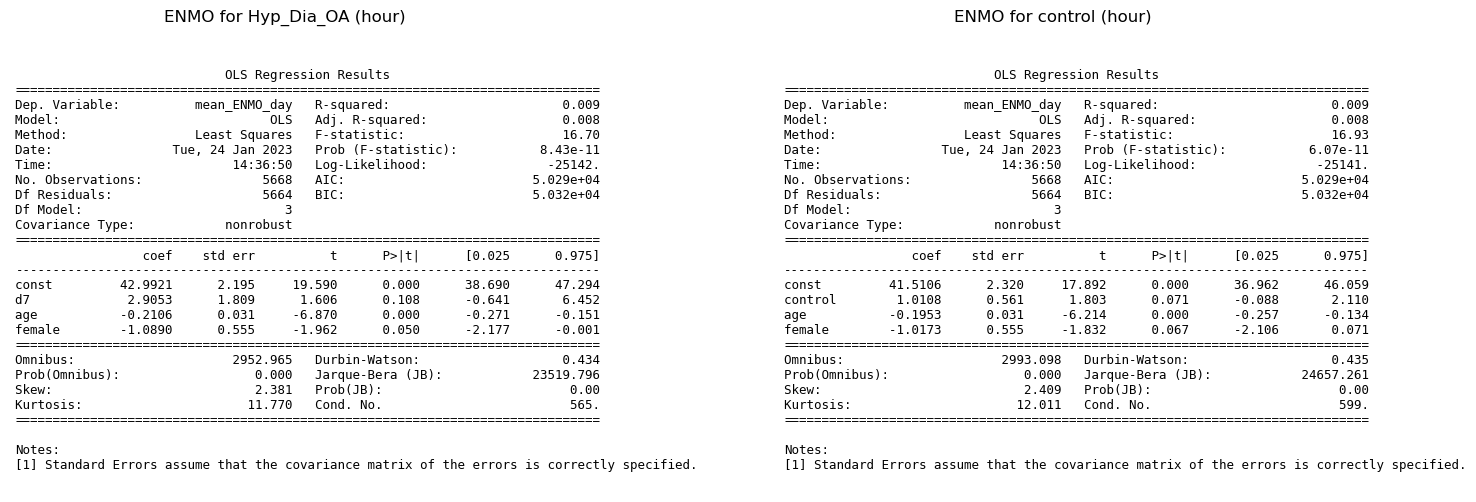

In [33]:
group = ["Hyp_Dia_OA", "control"]

YVar = df_day["mean_ENMO_day"]
XVar1 = df_day[["d7", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_day[["control", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))
for i in [0,1]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 9}, fontproperties = 'monospace')
    ax[i].set_title(f"ENMO for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

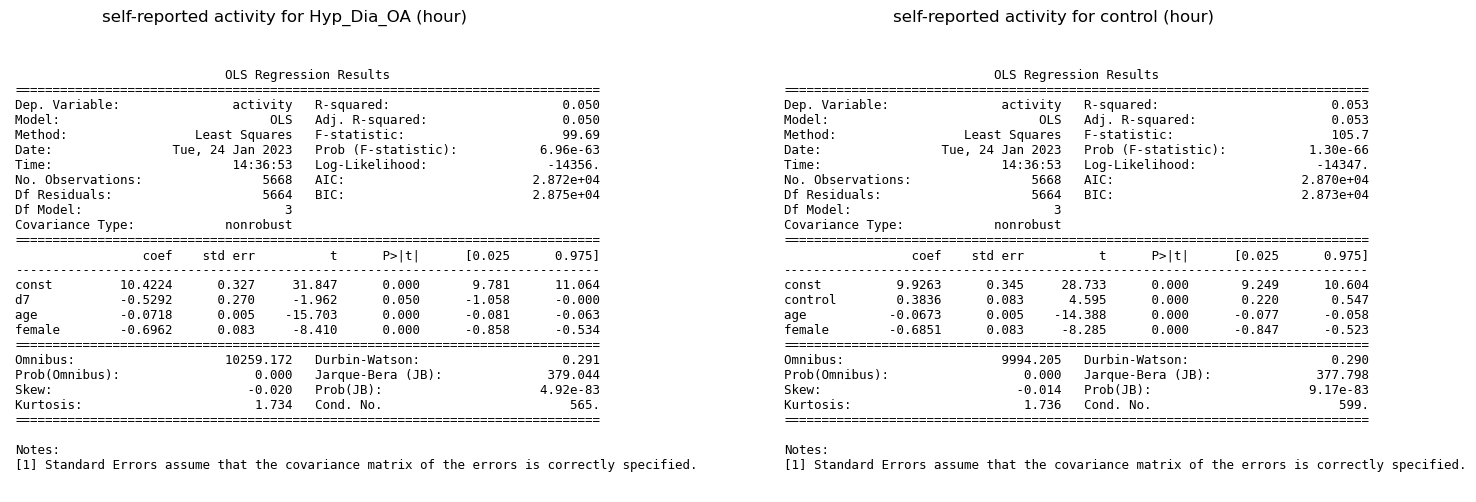

In [34]:
group = ["Hyp_Dia_OA", "control"]

YVar = df_day["activity"]
XVar1 = df_day[["d7", "age", "female"]]
XVar1 = sm.add_constant(XVar1)
models = [sm.OLS(YVar, XVar1).fit()]

XVar2 = df_day[["control", "age", "female"]]
XVar2 = sm.add_constant(XVar2)
models.append(sm.OLS(YVar, XVar2).fit())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))
for i in [0,1]:
    ax[i].text(0.01, 0.05, str(models[i].summary()), {'fontsize': 9}, fontproperties = 'monospace')
    ax[i].set_title(f"self-reported activity for {group[i]} (hour)")
    ax[i].set_axis_off()
fig.subplots_adjust(wspace=.4)    
plt.show()

Characteristics of the participants

total number of respondents

In [38]:
total_participants = df_stat[df_stat.columns[0]].count()
total_participants

856

Counting responents in each group

In [39]:
df_stat['disease']  = df_stat[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)
df_stat['disease'].value_counts()

control    383
d1         241
d4          68
d3          48
d5          46
d2          44
d7          20
d6           6
Name: disease, dtype: int64

<AxesSubplot:xlabel='disease'>

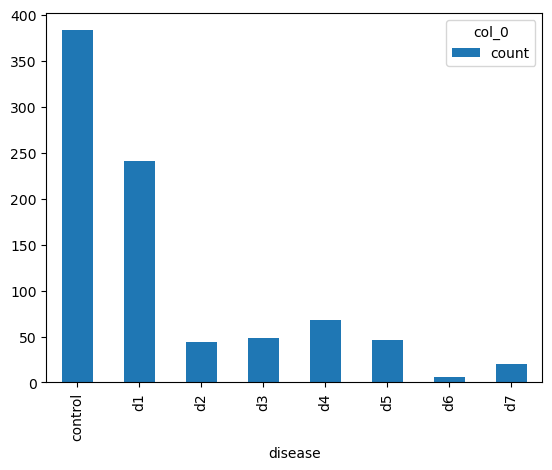

In [40]:
disease_table = pd.crosstab(index=df_stat['disease'], columns='count')
disease_table.plot(kind='bar')

Age mean and standard devation

In [41]:
st_dev_age = df_stat.groupby('disease')['age'].agg(['mean', 'std']) # for mean and std deviation
st_dev_age

,mean,std
disease,,
control,66.881985,8.529482
d1,70.952283,9.454537
d2,70.270455,8.690374
d3,70.043751,9.603056
d4,71.286765,7.044717
d5,70.734783,8.596956
d6,72.516667,7.085878
d7,71.655000,8.660587


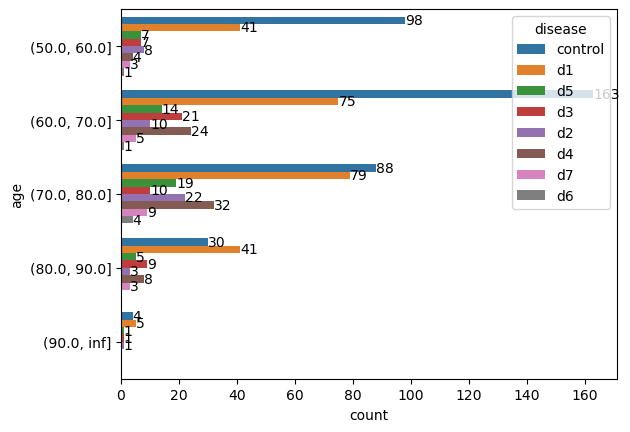

In [42]:
data = pd.DataFrame({
    "age": pd.cut(df_stat["age"], bins=[50, 60, 70, 80, 90, np.inf]),
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="age", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("age")
plt.show()

BMI mean and standard devation

In [43]:
st_dev_BMI = df_stat.groupby('disease')['bmi'].agg(['mean', 'std']) # for mean and std deviation
st_dev_BMI

,mean,std
disease,,
control,25.851241,4.853359
d1,28.207152,5.659255
d2,28.617814,4.356346
d3,26.259079,5.669901
d4,28.386495,8.002335
d5,29.501451,6.631926
d6,26.817510,3.482822
d7,28.093996,12.739242


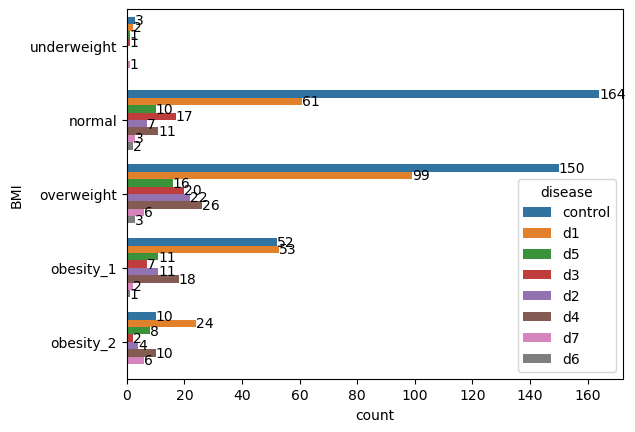

In [44]:
data = pd.DataFrame({
    "BMI": pd.cut(df_stat["bmi"], bins=[0, 18.5, 25, 30, 35, np.inf],
                            labels=["underweight", "normal", "overweight", "obesity_1", "obesity_2"]),
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="BMI", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

Number of participants depending on gender

In [45]:
count_sex = df_stat.groupby('disease')['female'].value_counts()
count_sex

disease  female
control  1         220
         0         163
d1       1         135
         0         106
d2       1          24
         0          20
d3       1          36
         0          12
d4       0          37
         1          31
d5       1          36
         0          10
d6       1           4
         0           2
d7       1          13
         0           7
Name: female, dtype: int64

in %:

In [46]:
for x in count_sex:
    print(x, '\t %.2f' % (x/total_participants*100))

220 	 25.70
163 	 19.04
135 	 15.77
106 	 12.38
24 	 2.80
20 	 2.34
36 	 4.21
12 	 1.40
37 	 4.32
31 	 3.62
36 	 4.21
10 	 1.17
4 	 0.47
2 	 0.23
13 	 1.52
7 	 0.82


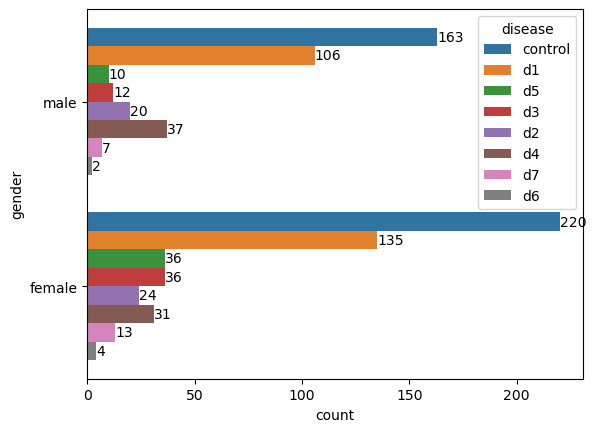

In [47]:
data = pd.DataFrame({
    "gender": df_stat["female"],
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="gender", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_yticklabels(["male", "female"])
plt.show()

In [48]:
df_stat['country'].value_counts()

Poland            129
Germany           116
Czech Republic    105
Slovenia          100
Belgium            81
France             79
Spain              72
Sweden             71
Italy              67
Denmark            36
Name: country, dtype: int64

In [49]:
def map_country_num(df, columns: list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Belgium': 23,
            'Czech Republik': 28,
            "Denmark": 18,
            'France': 17,
            'Germany': 12,
            'Italy': 16,
            'Poland': 29,
            'Slovenia': 34,
            'Spain': 15,
            'Sweden': 13,
        })
    return df

df_stat = map_country_num(df_stat, ["country"])
df_stat['country'].value_counts()

29.0    129
12.0    116
34.0    100
23.0     81
17.0     79
15.0     72
13.0     71
16.0     67
18.0     36
Name: country, dtype: int64

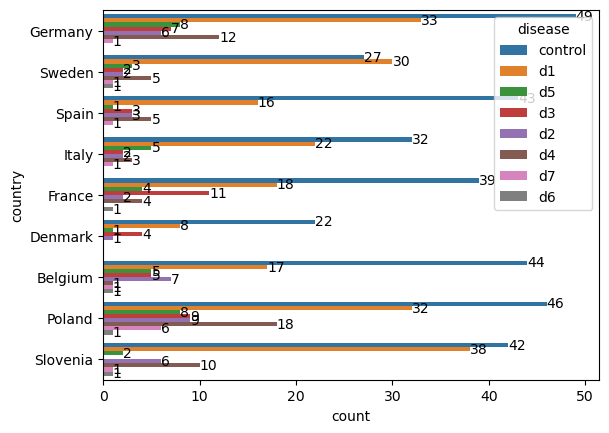

In [19]:
data = pd.DataFrame({
    "country": df_stat["country"],
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="country", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_yticklabels(["Germany", "Sweden", "Spain", "Italy", "France",  "Denmark", "Belgium", "Poland", "Slovenia"])
plt.show()

In [50]:
df_stat['OxCGRT_stay_at_home'].value_counts()

No restrictions    783
Essential only      49
Stay at home        24
Name: OxCGRT_stay_at_home, dtype: int64

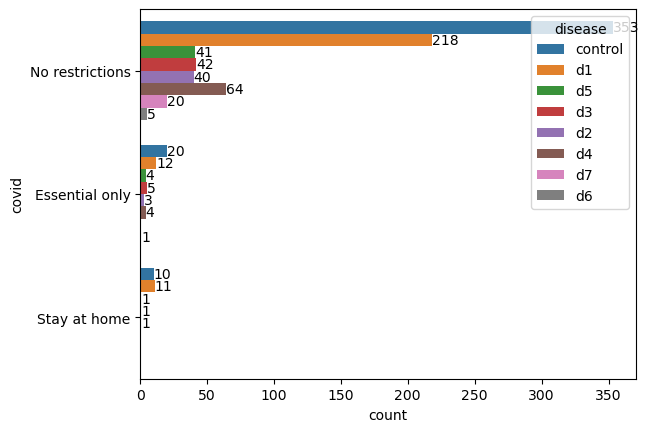

In [51]:
data = pd.DataFrame({
    "covid": df_stat["OxCGRT_stay_at_home"],
    "disease": df_stat["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="covid", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
#ax.set_yticklabels(["No restrictions","Essential only","Stay at home"])
plt.show()

In [52]:
'''
0–39 ENMO = Inactivity, 40–99 = Light activity, 100–399 = Moderate activity and ≥400 ENMO = Vigorous activity

WHO recommendation:
150 min in MPA per week or
75 min VPA per week 
'''

LPA_t = 39
MPA_t = 99
VPA_t = 399

conditions = [
    (df["ENMO_hour"] <= LPA_t),
    (df["ENMO_hour"] > LPA_t) & (df["ENMO_hour"] <= MPA_t),
    (df["ENMO_hour"] > MPA_t) & (df["ENMO_hour"] <= VPA_t),
    (df["ENMO_hour"] > VPA_t)
]

behaviour = ["Inactive", "LPA", "MPA", "VPA"]
df["behaviour"] = np.select(conditions, behaviour)
df["behaviour"].value_counts()

Inactive    103026
LPA          25705
MPA           5482
VPA             18
Name: behaviour, dtype: int64

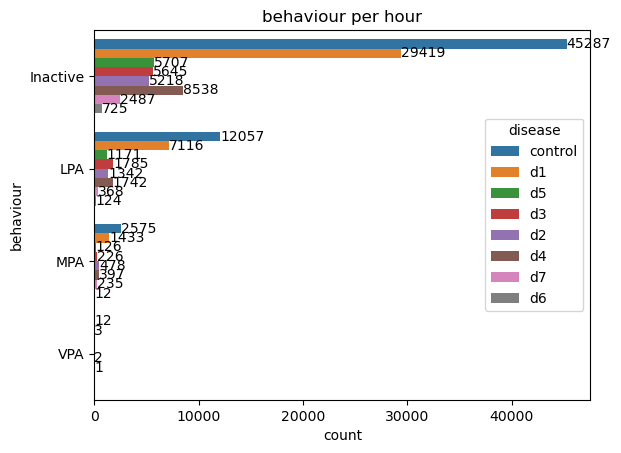

In [55]:
data = pd.DataFrame({
    "behaviour": df["behaviour"],
    "disease": df["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="behaviour", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("behaviour per hour")
plt.show()

In [58]:
df_wide = pd.pivot(df, index=["mergeid","hour"], columns="measurementday", values="behaviour")
df_wide.head()

measurementday                 1         2         3         4         5  \
mergeid      hour                                                          
Bf-031257-01 10am-11am  Inactive  Inactive       LPA  Inactive  Inactive   
             10pm-11pm  Inactive  Inactive  Inactive  Inactive  Inactive   
             11am-12pm  Inactive  Inactive       LPA  Inactive  Inactive   
             11pm-12am  Inactive  Inactive  Inactive  Inactive  Inactive   
             12am-1am        NaN  Inactive  Inactive  Inactive  Inactive   

measurementday                 6         7  
mergeid      hour                           
Bf-031257-01 10am-11am  Inactive  Inactive  
             10pm-11pm  Inactive  Inactive  
             11am-12pm  Inactive  Inactive  
             11pm-12am  Inactive  Inactive  
             12am-1am   Inactive  Inactive